In [13]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import umap

import pytorch_lightning as pl

from wcd_vae.data import get_dataloader_from_adata
from wcd_vae.model import VAE, VAEConfig, Discriminator, VAEDiscriminator, VAEWasserstein, VAE_OT
from wcd_vae.metrics import compute_metrics

In [14]:
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [15]:
# Load the anndata object (adjust path if needed)
anndata_path = "../data/immune.h5ad"
anndata = ad.read_h5ad(anndata_path)
anndata.layers["normalized"] = anndata.X

anndata = anndata[anndata.obs["batch"].isin(["MCA_BM_2", "MCA_BM_3"])].copy()

# Find/subset HVGs & swap to raw counts
import scanpy as sc
sc.pp.highly_variable_genes(anndata, n_top_genes=3000, batch_key="batch")
anndata = anndata[:, anndata.var["highly_variable"]].copy()
anndata.X = anndata.layers["counts"]

In [16]:
# for each broad type, print the number of cells
broad_type_counts = anndata.obs["batch"].value_counts()
print("Broad type counts:")
print(broad_type_counts)

Broad type counts:
batch
MCA_BM_2    13015
MCA_BM_3     8164
Name: count, dtype: int64


In [17]:
# for each sample, print the number of cells
species_counts = anndata.obs["species"].value_counts()
print("\nSpecies counts:")
print(species_counts)


Species counts:
species
Mouse    21179
Name: count, dtype: int64


In [18]:
# for each final_annotation, print the number of cells
final_annotation_counts = anndata.obs["final_annotation"].value_counts()
print("\nFinal annotation counts:")
print(final_annotation_counts)


Final annotation counts:
final_annotation
Neutrophils                   13516
Monocyte progenitors           4491
Lymphocyte progenitors         1127
Erythrocytes                    746
B cells                         320
Megakaryocyte progenitors       319
Monocytes                       297
Basophils                       228
Eosinophil progenitor cell      135
Name: count, dtype: int64


In [19]:
config = VAEConfig(
    input_dim=anndata.shape[1],
    latent_dim=32,
    encoder_hidden_dims=[128, 128],
    decoder_hidden_dims=[128, 128],
    dropout=0.2,
    batchsize=128,
    num_epochs=1_000,
    lr=1e-5,
    weight_decay=1e-5,
    kl_anneal_start=10,
    kl_anneal_end=50,
    kl_anneal_max=1.0,
    use_batchnorm=True,
    zinb=True,
    recon_weight=1,
    variational=True,
)

In [20]:
# Get test loader
_, test_loader, domain_encoder, cell_encoder = get_dataloader_from_adata(
    anndata, by="batch", batch_size=config.batchsize, num_workers=0, cell_label="final_annotation"
)

In [21]:
ckpt_dir = "/workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints"
ckpt_files = sorted(glob.glob(os.path.join(ckpt_dir, "*.ckpt")))
print("Found checkpoints:", ckpt_files)

Found checkpoints: ['/workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints/train_vae-epoch=180-val_loss=4.90.ckpt']


In [22]:
def load_and_eval(model_class, ckpt_path, config, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Instantiate and load model
    if model_class == VAE:
        model = VAE.load_from_checkpoint(ckpt_path, config=config, linear_decoder=False)
        eval_model = model
    elif model_class == VAEDiscriminator:
        vae = VAE(config, linear_decoder=True)
        critic = Discriminator(config.latent_dim, critic=False)
        model = VAEDiscriminator.load_from_checkpoint(ckpt_path, vae=vae, critic=critic)
        eval_model = model.vae
    elif model_class == VAEWasserstein:
        vae = VAE(config, linear_decoder=True)
        critic = Discriminator(config.latent_dim, critic=True)
        model = VAEWasserstein.load_from_checkpoint(ckpt_path, vae=vae, critic=critic)
        eval_model = model.vae
    elif model_class == VAE_OT:
        model = VAE_OT.load_from_checkpoint(ckpt_path, config=config, linear_decoder=False)
        eval_model = model
    else:
        raise ValueError("Unknown model class")

    model.eval()
    model = model.to(device)
    eval_model = eval_model.to(device)
    eval_model.eval()

    # Compute embeddings
    embeddings = []
    batches = []
    cell_type = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {os.path.basename(ckpt_path)}"):
            x, batch_label, cell_label = batch
            x, batch_label, cell_label = x.to(device), batch_label.to(device), cell_label.to(device)
            z, logvar = eval_model.encode(x)
            embeddings.append(z.cpu())
            batches.append(batch_label.cpu())
            cell_type.append(cell_label.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    batches = torch.cat(batches, dim=0)
    cell_type = torch.cat(cell_type, dim=0)

    # Compute metrics
    metrics_dict = compute_metrics(
        embeddings=embeddings,
        batch_labels=batches,
        cell_type_labels=cell_type,
    )
    return embeddings, batches, cell_type, metrics_dict

In [23]:
# Map checkpoint names to model classes (adjust as needed)
model_map = {
    "vae-": VAE,
    "vae_uot": VAE_OT,
    "vae_d": VAEDiscriminator,
    "vae_c": VAEWasserstein,
}

results = {}

for ckpt_path in ckpt_files:
    # Guess model type from filename
    for key, model_class in model_map.items():
        if key in os.path.basename(ckpt_path).lower():
            print(f"Evaluating checkpoint {ckpt_path} as {key}")
            embeddings, batches, cell_type, metrics_dict = load_and_eval(
                model_class, ckpt_path, config, test_loader
            )
            results[key] = {
                "embeddings": embeddings,
                "batches": batches,
                "cell_type": cell_type,
                "metrics": metrics_dict,
            }
            print(f"Metrics for {key}:")
            for k, v in metrics_dict.items():
                print(f"  {k}: {v}")
            break

Evaluating checkpoint /workspaces/wasserstein-critic-deconfounding/notebooks/checkpoints/train_vae-epoch=180-val_loss=4.90.ckpt as vae-


Evaluating train_vae-epoch=180-val_loss=4.90.ckpt: 100%|██████████| 34/34 [00:00<00:00, 515.72it/s]


Metrics for vae-:
  batch_entropy: 0.6931471824645996
  ilisi_batch: 2.0
  clisi_celltype: 1.2461538314819336
  silhouette_score: -0.23473964631557465
  normalized_mutual_info: 0.0004488922678014299


/opt/conda/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


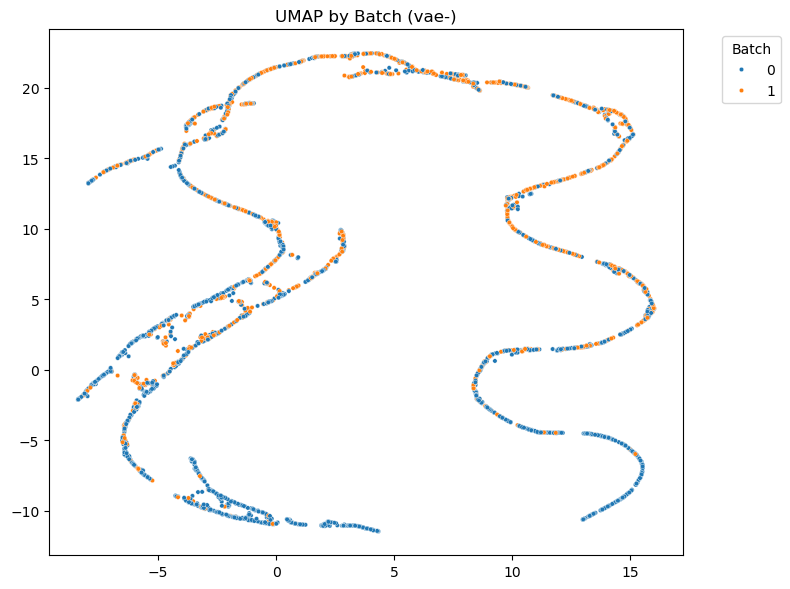

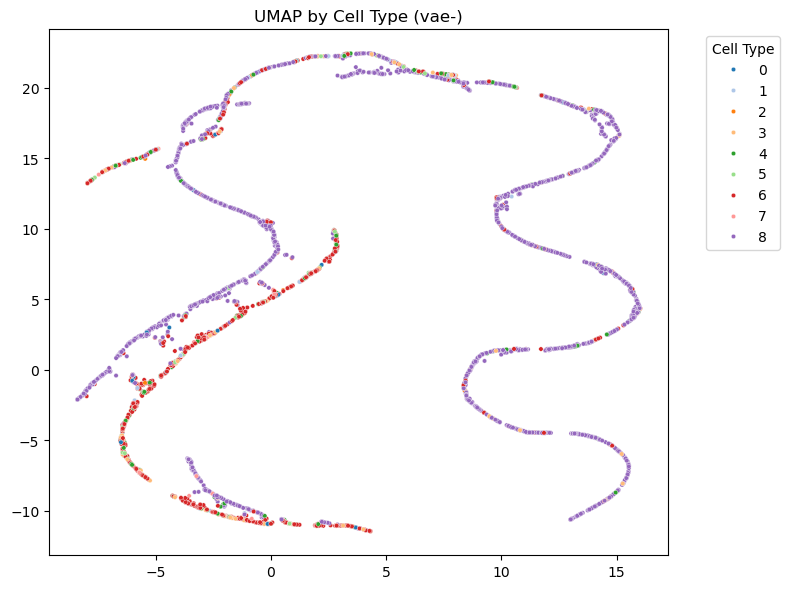

In [24]:
# Example: UMAP visualization for each model
for key, res in results.items():
    embeddings_np = res["embeddings"].numpy()
    batches_np = res["batches"].argmax(dim=1).numpy()
    cell_type_np = res["cell_type"].argmax(dim=1).numpy()

    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding_2d = umap_model.fit_transform(embeddings_np)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=batches_np, palette="tab10", s=10)
    plt.title(f"UMAP by Batch ({key})")
    plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=cell_type_np, palette="tab20", s=10)
    plt.title(f"UMAP by Cell Type ({key})")
    plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()